In [6]:
# system imports
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
from numpyro.infer import MCMC, NUTS

# relative imports
os.chdir('/Users/martinmarek/Google Drive/UCL/STAT0035/bnn-regression')
from core import models
from core import distributions
from core import utils
from core.hmc import hmc_sampler
from core.nuts import nuts
from core.rwmh import rwmh_sampler
from core.sgd import train_sgd

In [7]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## generate synthetic regression data

In [75]:
# define x
x_full = jnp.linspace(-2, 2, 500)[:, None]
step = 0.05
x_train = jnp.concatenate([jnp.arange(-1.5, 0, step), jnp.arange(1, 1.5, step)])[:, None]
N, C = x_train.shape

# define true model
key = jax.random.PRNGKey(7568)
layer_dims = 3*[10]
stdev = 1
predict_fn, params_true = models.make_nn(key, x_train, layer_dims, stdev)

# generate y
y_full = predict_fn(x_full, params_true)[:, 0]
y_train = predict_fn(x_train, params_true)[:, 0]

# standardize y
mean, sd = y_full.mean(), y_full.std()
y_full = (y_full - mean) / sd
y_train = (y_train - mean) / sd

# add noise
sigma_obs = 0.3
key, _ = jax.random.split(key)
y_train += sigma_obs * jax.random.normal(key, [N])

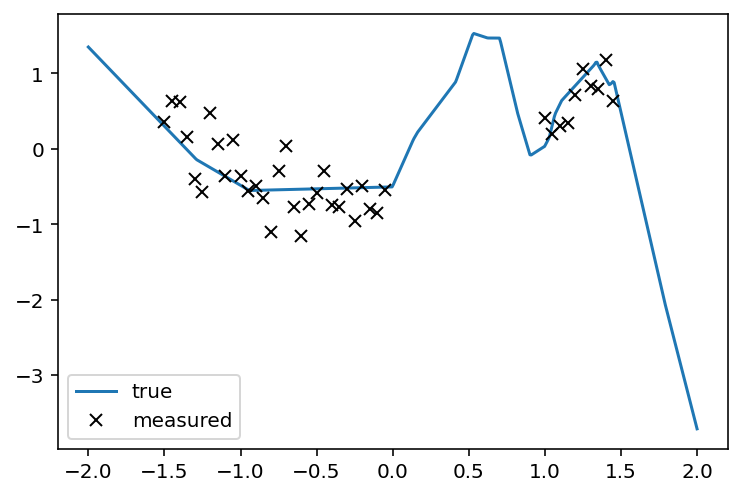

In [76]:
fig, ax = plt.subplots()
ax.plot(x_full[:, 0], y_full, label='true')
ax.plot(x_train[:, 0], y_train, 'kx', label='measured')
ax.legend()
plt.show()

## define model

In [77]:
# define model
# - when using a large NN with a small dataset, the prior must be very flat so that it doesn't dominate the likelihood
layer_dims = 3*[10]
init_sd = 0.1
prior_sd = 10
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
params_init = jax.tree_map(lambda x: init_sd*x, params_init)
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [78]:
# TEST: NN params shape
print(jax.tree_map(lambda x: x.shape, params_init))

# TEST: prior, likelihood, posterior
print(log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

FlatMap({
  'linear': FlatMap({'b': (10,), 'w': (1, 10)}),
  'linear_1': FlatMap({'b': (10,), 'w': (10, 10)}),
  'linear_2': FlatMap({'b': (10,), 'w': (10, 10)}),
  'linear_3': FlatMap({'b': (2,), 'w': (10, 2)}),
})
-844.05164 -39.12847 -883.1801


## SGD

$$y_0 x^n = y_1$$
$$x^n = y_1/y_0$$
$$x = (y_1/y_0)^{1/n}$$

In [79]:
%%time
params_sgd, log_prob_sgd = train_sgd(params_init, log_likelihood_fn)

CPU times: user 820 ms, sys: 8.52 ms, total: 828 ms
Wall time: 845 ms


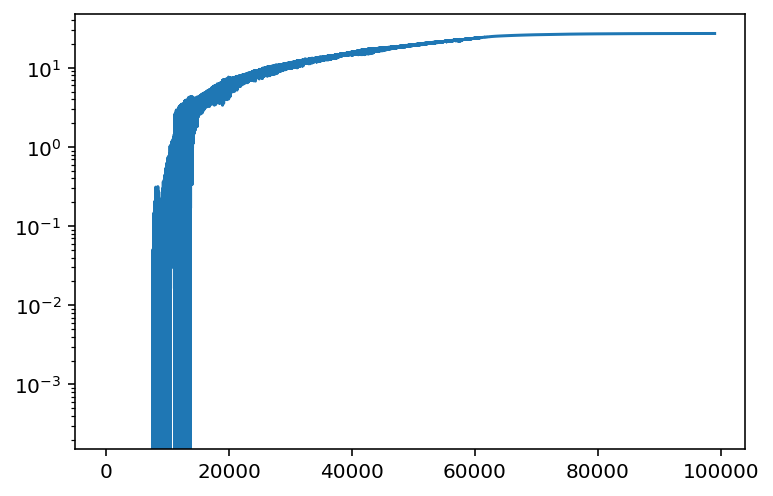

In [80]:
fig, ax = plt.subplots()
ax.plot(-log_prob_sgd[1000:])
plt.yscale('log')
plt.show()

## RWMH

In [85]:
%%time
key = jax.random.PRNGKey(0)
n_steps = 50
n_blind_steps = 10_000
step_size = 1e-3
params_rwmh = rwmh_sampler(params_sgd, log_posterior_fn, key, n_steps, n_blind_steps, step_size)

Avg. accept. prob.: 72.65%
CPU times: user 4.99 s, sys: 23 ms, total: 5.01 s
Wall time: 5.02 s


## HMC

In [84]:
%%time
n_steps = 50
step_size = 1e-4
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)
params_hmc = hmc_sampler(params_sgd, log_posterior_fn, n_steps, n_leapfrog_steps, step_size, key)

Avg. accept. prob.: 88.32%
CPU times: user 10.3 s, sys: 53.6 ms, total: 10.3 s
Wall time: 10.4 s


## NUTS

In [34]:
# %%time
# # step_size=1e-5 is stable with 2**13 steps, but not more
# n_steps = 10
# step_size = 1e-5
# max_leapfrog_steps = 2 ** 13
# print(f'{max_leapfrog_steps=}')
# key = jax.random.PRNGKey(0)
# params_nuts = nuts(params_init, log_posterior_fn, step_size, key, n_steps, max_leapfrog_steps)

# numpyro

In [35]:
%%time
# this takes too long...
# potential_fn = lambda x: -log_posterior_fn(x)
# nuts_kernel = NUTS(potential_fn=potential_fn)
# mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=n_steps)
# mcmc.run(key, init_params=params_init)
# chain_numpyro = mcmc.get_samples()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.96 µs


# combined training

In [130]:
n_outer_steps = 5
n_inner_steps = 5
init_sd = 0.1
step_size = 1e-5
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)

params_mixed = []
for i in range(n_outer_steps):
    key, init_key, mcmc_key = jax.random.split(key, 3)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    params_sgd, log_prob_sgd = train_sgd(params_start, log_likelihood_fn)
    params_mixed += hmc_sampler(params_sgd, log_posterior_fn, n_inner_steps, n_leapfrog_steps, step_size, mcmc_key)

Avg. accept. prob.: 99.78%
Avg. accept. prob.: 99.74%
Avg. accept. prob.: 99.62%
Avg. accept. prob.: 99.79%
Avg. accept. prob.: 99.61%


## plot predictions

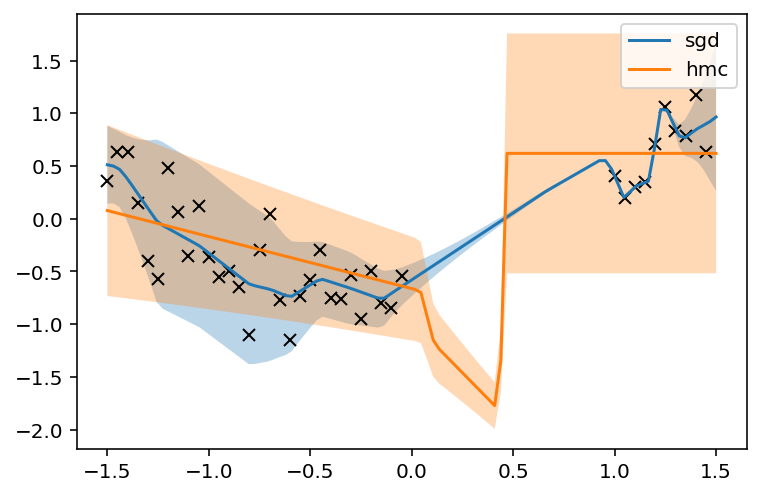

In [86]:
fig, ax = plt.subplots()

# plot training data
ax.plot(x_train[:, 0], y_train, 'kx')


# labeled results
labeled_params = {
    'sgd': params_sgd,
    # 'rwmh': params_rwmh[-1],
    'hmc': params_hmc[-1],
    # 'nuts': params_nuts[-1],
}

# plot predictions
x_full = jnp.linspace(-1.5, 1.5, 100)[:, None]
for label, params in labeled_params.items():
    y_hat = predict_fn(x_full, params)
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=label)

ax.legend(loc='upper right')
plt.show()

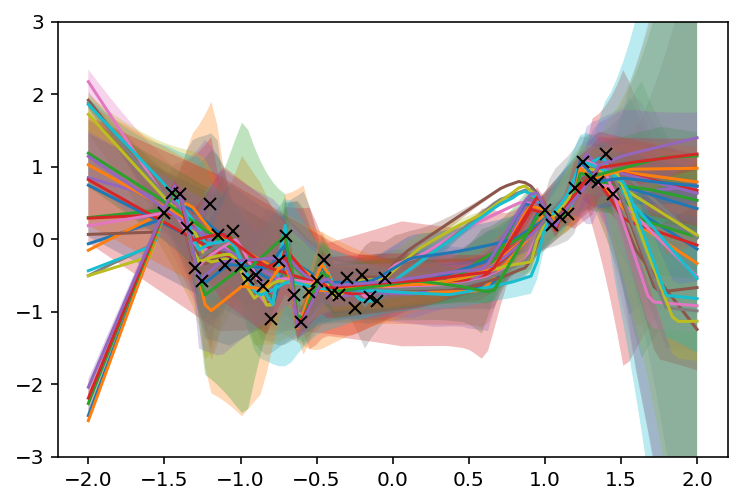

In [131]:
fig, ax = plt.subplots()

# plot predictions
x_full = jnp.linspace(-2, 2, 100)[:, None]
for i, params in enumerate(params_mixed):
    y_hat = predict_fn(x_full, params)
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=i)

# plot training data
ax.plot(x_train[:, 0], y_train, 'kx')
ax.set_ylim([-3, 3])

# ax.legend()
plt.show()

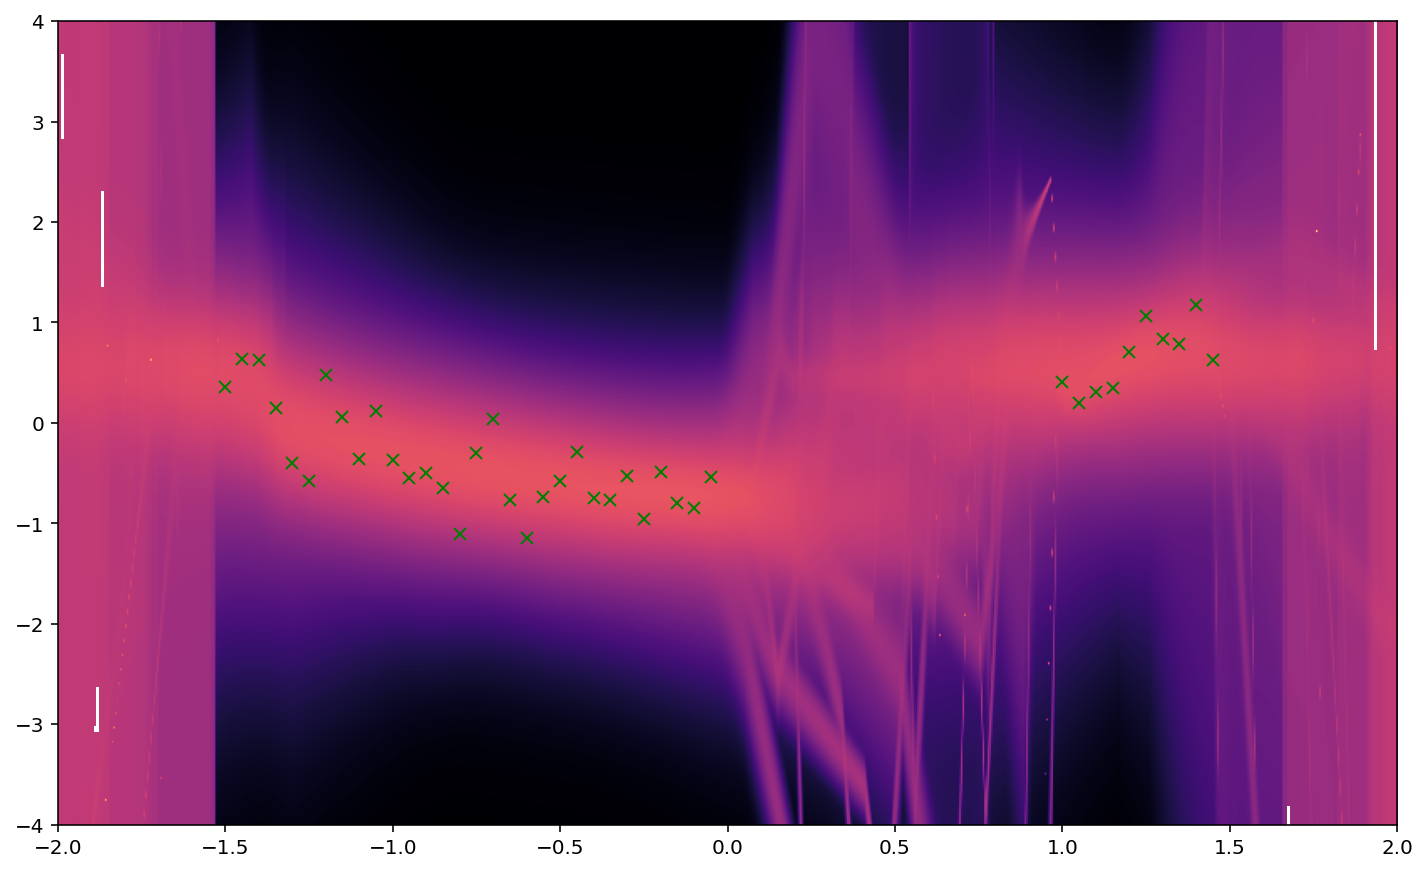

In [135]:
# create grid to evaluate posterior predictive density
nx, ny = 800, 400
x_full = jnp.linspace(-2, 2, nx)
y_full = jnp.linspace(-4, 4, ny)
z_full = jnp.zeros([nx, ny])

# average over posterior samples
warmup_steps = 10
used_steps = len(params_hmc) - warmup_steps
for params in params_hmc[warmup_steps:]:
    y_hat = predict_fn(x_full[:, None], params)
    mean = y_hat[:, 0]
    std = y_hat[:, 1]
    log_prob = distributions.gaussian_log_pdf(y_full[None, :], mean[:, None], std[:, None])
    log_prob = jnp.nan_to_num(log_prob)
    z_full += jnp.exp(log_prob) / used_steps

# density plot
fig, ax = plt.subplots(figsize=[12, 8])
extent = [x_full[0], x_full[-1], y_full[0], y_full[-1]]
ax.imshow(z_full.T**(1/8), origin='lower', cmap='magma', extent=extent, aspect=0.3)
ax.plot(x_train[:, 0], y_train, 'x', color='green')
plt.show()

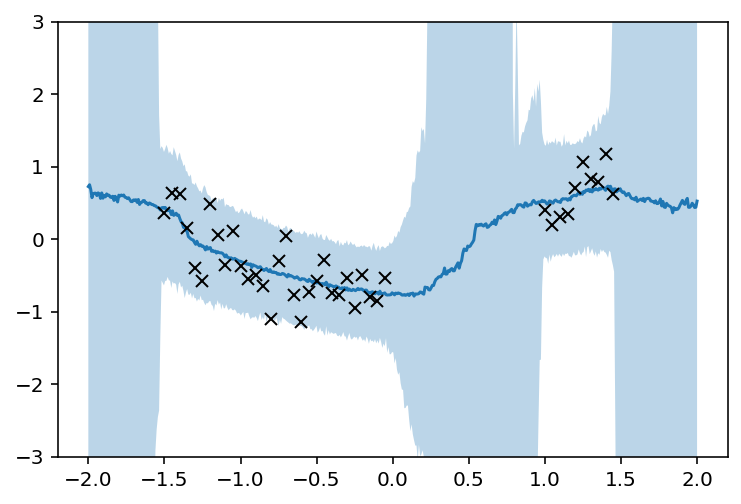

In [139]:
key = jax.random.PRNGKey(0)
alpha = 0.05
warmup_steps = 10
used_steps = len(params_hmc) - warmup_steps
nx = 500
x_full = jnp.linspace(-2, 2, nx)
n_samples = 1_000
n_samples_per_step = n_samples // used_steps

samples = jnp.zeros([nx, used_steps, n_samples_per_step])
for i, params in enumerate(params_hmc[warmup_steps:]):
    key, _ = jax.random.split(key)
    y_hat = predict_fn(x_full[:, None], params)
    mean = y_hat[:, 0]
    std = y_hat[:, 1]
    current_samples = mean[:, None] + std[:, None] * jax.random.normal(key, [nx, n_samples_per_step])
    samples = samples.at[:, i, :].set(current_samples)

# flatten sampled predictions across posterior samples
samples = samples.reshape([nx, used_steps*n_samples_per_step])

# get posterior predictive quntiles
quantiles = jnp.quantile(samples, jnp.array([alpha/2, 0.5, 1-alpha/2]), axis=1)
    
# CI plot
fig, ax = plt.subplots()
ax.fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3)
ax.plot(x_full, quantiles[1, :])
ax.plot(x_train[:, 0], y_train, 'kx')
ax.set_ylim([-3, 3])
plt.show()

In [ ]:
# fast MCMC inference
# in parallel:
#  - start with multiple random inits
#  - train each model with SGD until convergence
#  - *then* run MCMC on each model
# (afterwards, concatenate outputs)